# Clothes Segmentation. Experiment 4

**Author:** Dmytro Lopushanskyy  
**Date:** 14 June 2022  

# Experiment Description

## New Model!

I wanted to try a different model and see if it yields better performance. I found an interesting implementation of U2NET on GitHub that is based on a two-level nested U-structure architecture.

## Decreased Epochs

Since the model is more heavy than UNET, I needed to decrease the number of epochs to be able to run it in the proper time. Consequently, I have decrease log parameter to every 100 steps.


# Experiment Results

The model was not able to learn successfully. The training metrics are very chaotic and show that the model was not able to capture meaningful information.  

I think one of the reasons might be that the model is larger than UNet and it is more diffucult to train it well. Moreover, I needed to decrease the number of epochs. 

# Experiment Notebook

In [1]:
class_grouping = { 
    0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 1, 10: 2, 
    11: 1, 12: 1, 13: 3, 14: 3, 15: 3, 16: 4, 17: 5, 18: 5, 19: 6, 
    20: 7, 21: 7, 22: 7, 23: 7, 24: 8, 25: 4, 26: 8, 27: 0, 28: 4, 29: 4, 
    30: 4, 31: 5, 32: 2, 33: 4, 34: 6, 35: 1, 36: 2, 37: 9, 38: 9, 39: 9, 
    40: 9, 41: 9, 42: 9, 43: 9, 44: 9, 45: 9
}

new_class_desc = {
    0: '(shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)',
    1: '(jacket, vest, coat, jumpsuit, cape, zipper)',
    2: '(pants, pocket, shorts, skirt, dress, applique)',
    3: '(glasses, hat, headband, head covering, hair accessory)',
    4: '(tie, scarf, collar, lapel, epaulette, neckline)',
    5: '(glove, sleeve, watch)',
    6: '(belt, buckle)',
    7: '(leg warmer, tights, stockings, sock, shoe)',
    8: '(bag, wallet, umbrella)',
    9: 'decorations'
}

## Config

In [2]:
config = {
    'dataset_root': './',
    'img_size': [64, 64],
    'train': {
        'img_path': './train'
    },
    'test': {
        'img_path': './test'
    },
    'model': {
        'lr': '1e-1',
        'num_classes': 11,  # reduced here from 49 to 10
        'num_layers': 5,
        'features_start': 64,
        'bilinear': False,
        'grad_batches': 1,
        'epochs': 50
    },
    'ignore_value': 10,
    'batch_size': 64,
    'data_size': -1  # take all data
}

## Imports

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import yaml
import random
import pickle
import numpy as np
import pandas as pd
import json
import cv2
import torch
import torch.nn.functional as F
import albumentations as albu
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.classification import Accuracy
from torchmetrics import F1Score, JaccardIndex  # IoU, F1
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## EDA

In [4]:
json_file_path = f'{config["dataset_root"]}/label_descriptions.json'
train_csv_path = f'{config["dataset_root"]}/train.csv'

with open(json_file_path, 'r') as j:
    label_descriptions = json.loads(j.read())
    
train_df = pd.read_csv(train_csv_path)

In [5]:
train_df

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32
...,...,...,...,...,...
331208,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2712731 8 2715725 23 2718719 39 2721713 55 272...,3000,2001,28
331209,ffffbf7014a9e408bfbb81a75bc70638.jpg,71179 1 71678 3 72178 4 72678 4 73178 5 73679 ...,500,375,33
331210,ffffbf7014a9e408bfbb81a75bc70638.jpg,116648 5 117148 16 117648 22 118148 26 118647 ...,500,375,31
331211,ffffbf7014a9e408bfbb81a75bc70638.jpg,67711 1 68210 1 68709 2 69204 2 69208 3 69705 ...,500,375,31


## Dataset Initialization

In [6]:
class FashionDataset(Dataset):
    ignore_value = config['ignore_value']
    
    def __init__(self, config, dataset_type='train', transform=None):
        self.type = dataset_type
        self.root_dir = config['dataset_root']
        self.imgs_path = os.path.join(self.root_dir, config['train']['img_path'])
        self.img_size = config['img_size']
        self.transform = transform
        
        self.img_files = os.listdir(self.imgs_path)
        data_size = config['data_size']
        if data_size > 0:
            self.img_files = os.listdir(self.imgs_path)[:data_size]
        
        
    def __len__(self):
        return len(self.img_files)
    
    def make_mask_img(self, segment_df):
        seg_width = segment_df['Width'].iat[0]
        seg_height = segment_df['Height'].iat[0]
        seg_img = np.full(seg_width*seg_height, self.ignore_value, dtype=np.int32)
        for encoded_pixels, class_id in zip(segment_df['EncodedPixels'].values, segment_df['ClassId'].values):
            pixel_list = list(map(int, encoded_pixels.split(" ")))
            for i in range(0, len(pixel_list), 2):
                start_index = pixel_list[i] - 1
                index_len = pixel_list[i+1] - 1
                cls_id = int(class_id.split("_")[0])
                new_cls_id = class_grouping[cls_id]
                seg_img[start_index:start_index+index_len] = new_cls_id
        seg_img = seg_img.reshape((seg_height, seg_width), order='F')
        seg_img = cv2.resize(seg_img, self.img_size, interpolation=cv2.INTER_NEAREST)
        return seg_img
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        
        img = cv2.imread(f'{self.imgs_path}/{img_name}')
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_NEAREST)
        segment_df = (train_df[train_df['ImageId'] == img_name]).reset_index(drop=True)
        if segment_df['ImageId'].nunique() != 1:
            raise Exception('Index Range Error')
            
        mask = self.make_mask_img(segment_df)
        img = img.transpose((2, 0, 1))  # HWC -> CHW
        
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        return np.float32(img / 255), np.int32(mask)
    
def get_categories(mask):
    """ Get category description from the mask """
    categories = np.unique(mask)
    categories = np.delete(categories, np.where(categories == config['ignore_value']))  # filter
    categories = [f"{int(idx)} - {new_class_desc[idx]}" for idx in categories]
    return categories

In [7]:
dataset = FashionDataset(config)

# U2Net

U2Net architecture used from [this repo](https://github.com/levindabhi/cloth-segmentation)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate
        )
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self, x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):

    src = F.upsample(src, size=tar.shape[2:], mode="bilinear")

    return src


### RSU-7 ###
class RSU7(nn.Module):  # UNet07DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(torch.cat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6, hx7
        del hx6d, hx5d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup, hx5dup, hx6dup
        """

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Module):  # UNet06DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup, hx5dup
        """

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Module):  # UNet05DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5
        del hx4d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup
        """

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Module):  # UNet04DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4
        del hx3d, hx2d
        del hx2dup, hx3dup
        """

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Module):  # UNet04FRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(torch.cat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(torch.cat((hx2d, hx1), 1))

        """
        del hx1, hx2, hx3, hx4
        del hx3d, hx2d
        """

        return hx1d + hxin


### U^2-Net small ###
class U2NETP(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NETP, self).__init__()

        self.stage1 = RSU7(in_ch, 16, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 16, 64)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(64, 16, 64)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(64, 16, 64)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(64, 16, 64)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(64, 16, 64)

        # decoder
        self.stage5d = RSU4F(128, 16, 64)
        self.stage4d = RSU4(128, 16, 64)
        self.stage3d = RSU5(128, 16, 64)
        self.stage2d = RSU6(128, 16, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(64, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):
        hx = x

        # stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # decoder
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d, hx1d
        del hx6up, hx5dup, hx4dup, hx3dup, hx2dup
        """

        return d0  # d1, d2, d3, d4, d5, d6

## Own Model

In [9]:
class SegModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.lr = float(config['model']['lr'])
        self.model = U2NETP(3, self.config['model']['num_classes'])
        self.accuracy = Accuracy(num_classes=self.config['model']['num_classes'], 
                                 ignore_index=config['ignore_value'],
                                 mdmc_average='global')
        self.jaccard = JaccardIndex(num_classes=self.config['model']['num_classes'],
                                    ignore_index=config['ignore_value'],
                                    mdmc_average='global')
        self.f1 = F1Score(num_classes=self.config['model']['num_classes'], 
                          ignore_index=config['ignore_value'],
                          mdmc_average='global')
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        
        out = self(img)
        joined_mask = out.argmax(axis=1)  #.argmax(axis=1)
        
        loss_val = F.cross_entropy(out, mask, ignore_index=FashionDataset.ignore_value)
        
        acc_res = self.accuracy(joined_mask, mask)
        jac_res = self.jaccard(joined_mask, mask)
        f1_res = self.f1(joined_mask, mask)
        
        self.log('train_loss', loss_val)
        self.log("train_acc", acc_res)
        self.log("train_jaccard", jac_res)
        self.log("train_f1", f1_res)
        
        return loss_val
    
    def test_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        
        out = self(img)
        joined_mask = out.argmax(axis=1)
        
        loss_val = F.cross_entropy(out, mask, ignore_index=FashionDataset.ignore_value)
        
        acc_res = self.accuracy(joined_mask, mask)
        jac_res = self.jaccard(joined_mask, mask)
        f1_res = self.f1(joined_mask, mask)
        
        self.log('test_loss', loss_val)
        self.log("test_acc", acc_res)
        self.log("test_jaccard", jac_res)
        self.log("test_f1", f1_res)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

## Lightning Data Module

In [10]:
class FasionDataModel(pl.LightningDataModule):
    def __init__(self, config):
        self.data_config = config
        self.batch_size = config['batch_size']
        self.prepare_data_per_node = True
        self._log_hyperparams = True
        
        self.transform = albu.Compose([
            albu.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=10, p=0.4),
            albu.OneOf(
                [
                    albu.RandomBrightnessContrast(),
                    albu.MedianBlur(),
                ], 
                p=0.5
            )
        ])
        
        full_dataset = FashionDataset(config, transform=self.transform)
        train_size = int(len(full_dataset) * 0.8)
        val_size = len(full_dataset) - train_size
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=64)
    
    def test_dataloader(self):
        # evaluate on validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=64)

In [11]:
model = SegModel(config)
data_module = FasionDataModel(config)

In [12]:
wandb_logger = WandbLogger()

wandb: Currently logged in as: dlopushanskyy. Use `wandb login --relogin` to force relogin


In [13]:
logger = TensorBoardLogger("tb_logs", name="fashion_model")
trainer = pl.Trainer(
    gpus=[0],
    accelerator="auto",
    logger=wandb_logger,
    max_epochs=config['model']['epochs'],
    accumulate_grad_batches=config['model']['grad_batches'],
    limit_train_batches=0.25,
    limit_test_batches=0.25,
    log_every_n_steps=100
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name     | Type         | Params
------------------------------------------
0 | model    | U2NETP       | 1.2 M 
1 | accuracy | Accuracy     | 0     
2 | jaccard  | JaccardIndex | 0     
3 | f1       | F1Score      | 0     
------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.666     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [15]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
         test_f1                    0.0
      test_jaccard                  0.0
        test_loss         2.9101112374163166e+22
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.9101112374163166e+22,
  'test_acc': 0.0,
  'test_jaccard': 0.0,
  'test_f1': 0.0}]

## Save Model

In [16]:
pickle.dump(model, open('output/fashion-model-exp-5.pkl', 'wb'))

# WandB Visualization

### Unfortunately, the metrics look chaotic (similar to first experiment). The model did not learn anything.

![img](https://user-images.githubusercontent.com/25267308/173838735-14c55018-0c6a-4bcb-98b2-4c12751b657a.png)

# See Results

Get random images from the test dataset to see the performance

In [17]:
N_IMAGES = 3

In [18]:
model.eval()
test_loader = data_module.train_dataloader()
img, mask_test = next(iter(test_loader))
img = img.float()

In [19]:
y = model.forward(img)

In [20]:
joined_mask = y.argmax(axis=1)[:N_IMAGES]

In [21]:
img = np.array(img[:N_IMAGES])
mask_test = mask_test[:N_IMAGES]

Train Example 0

True Categories:
0 - (shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)
1 - (jacket, vest, coat, jumpsuit, cape, zipper)
2 - (pants, pocket, shorts, skirt, dress, applique)
3 - (glasses, hat, headband, head covering, hair accessory)
4 - (tie, scarf, collar, lapel, epaulette, neckline)
5 - (glove, sleeve, watch)
7 - (leg warmer, tights, stockings, sock, shoe)
8 - (bag, wallet, umbrella)
9 - decorations

Predicted Categories:
6 - (belt, buckle)

Train Example 1

True Categories:
0 - (shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)
1 - (jacket, vest, coat, jumpsuit, cape, zipper)
2 - (pants, pocket, shorts, skirt, dress, applique)
3 - (glasses, hat, headband, head covering, hair accessory)
4 - (tie, scarf, collar, lapel, epaulette, neckline)
5 - (glove, sleeve, watch)
7 - (leg warmer, tights, stockings, sock, shoe)
8 - (bag, wallet, umbrella)
9 - decorations

Predicted Categories:
6 - (belt, buckle)

Train Example 2

True Categories:
0 - 

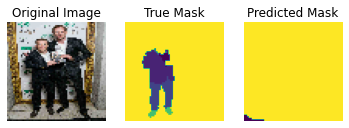

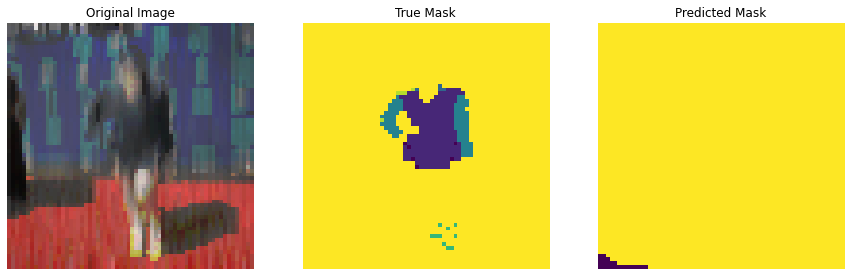

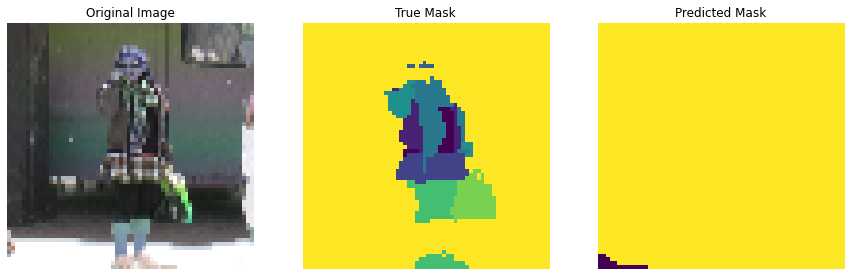

In [22]:
for i in range(N_IMAGES):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig = plt.figure()

    rows, cols = 1, 3

    fig.add_subplot(rows, cols, 1)
    plt.imshow(cv2.cvtColor(img[i].transpose((1, 2, 0)), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')

    fig.add_subplot(rows, cols, 2)
    plt.imshow(mask_test[i])
    plt.axis('off')
    plt.title('True Mask')

    fig.add_subplot(rows, cols, 3)
    plt.imshow(joined_mask[i])
    plt.axis('off')
    plt.title('Predicted Mask')

    plt.savefig(f'output/output_{i}.png')

    print(f'Train Example {i}\n')
    new_line_ch = '\n'
    print(f'True Categories:\n{new_line_ch.join(get_categories(mask_test))}\n')
    print(f'Predicted Categories:\n{new_line_ch.join(get_categories(joined_mask))}\n')

### The performance on test images is quite expected after looking at the training graphs. The model was not able to capture any meaningful information. Maybe there is some problem with the implementation or my usage, it is open for further debugging.

Next and final experiment is much better though!